Load libraries

In [3]:
from dotenv import load_dotenv
import os
import snowflake.connector
import pandas as pd
import logging
import numpy as np

import mlflow
from mlflow.models import infer_signature

In [4]:
## Set mlflow tracking uri

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

connect to snowflake

In [5]:
load_dotenv(dotenv_path="../cred.env")

conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse=os.getenv("SNOWFLAKE_WH"),
    database=os.getenv("SNOWFLAKE_DB"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
    role=os.getenv("SNOWFLAKE_ROLE")
)


query = "SELECT CURRENT_ROLE(), CURRENT_WAREHOUSE(), CURRENT_DATABASE(), CURRENT_SCHEMA();"
df = pd.read_sql(query, conn)
df.head()

C:\Users\prach\AppData\Local\Temp\ipykernel_1396\2922898121.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CURRENT_ROLE(),CURRENT_WAREHOUSE(),CURRENT_DATABASE(),CURRENT_SCHEMA()
0,CREDIT_RISK_SYSADMIN,CREDIT_RISK_WH,CREDIT_RISK_PREDICTION,CREDIT_DATA


Read Training datset


In [6]:
trn_query = "select * from Credit_risk_prediction.credit_data.cs_train"

train_dataset = pd.read_sql(trn_query, conn)

train_dataset.head()

train_dataset.isna().sum()






C:\Users\prach\AppData\Local\Temp\ipykernel_1396\1230699613.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train_dataset = pd.read_sql(trn_query, conn)


SRC_DLQ_TWO_YRS                         0
RVLV_UTLZ_UNSEC_LINES                   0
AGE                                     0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS        0
DEBT_RATIO                              0
MNTHLY_INCOME                       29731
NUM_TIMES_OPEN_CRDT_LINES_LOANS         0
NUM_TIMES_90_DAYS_LATE                  0
NUM_TIMES_REAL_ESTATE_LOAN_LINES        0
NUM_TIMES_60_59_DAYS_PAST_DUE           0
NUM_DEPEDENTS                        3924
dtype: int64

In [7]:
train_dataset.duplicated().sum()

np.int64(609)

In [8]:
train_dataset[train_dataset.duplicated(keep=False)]

,SRC_DLQ_TWO_YRS,RVLV_UTLZ_UNSEC_LINES,AGE,NUM_TIMES_PAST_DUE_IN_30_59_DAYS,DEBT_RATIO,MNTHLY_INCOME,NUM_TIMES_OPEN_CRDT_LINES_LOANS,NUM_TIMES_90_DAYS_LATE,NUM_TIMES_REAL_ESTATE_LOAN_LINES,NUM_TIMES_60_59_DAYS_PAST_DUE,NUM_DEPEDENTS
52,0,1.0,62,0,0.0,NaN,1,0,0,0,0.0
331,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
530,0,0.0,82,0,0.0,NaN,3,0,0,0,0.0
1250,0,0.0,84,0,0.0,NaN,1,0,0,0,0.0
1669,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149139,0,0.0,77,0,0.0,NaN,2,0,0,0,0.0
149431,0,1.0,25,0,0.0,NaN,1,0,0,0,NaN
149472,0,1.0,84,0,0.0,NaN,1,0,0,0,0.0
149769,0,1.0,23,98,0.0,NaN,0,98,0,98,NaN


In [9]:
train_dataset.nunique()

SRC_DLQ_TWO_YRS                          2
RVLV_UTLZ_UNSEC_LINES               125728
AGE                                     86
NUM_TIMES_PAST_DUE_IN_30_59_DAYS        16
DEBT_RATIO                          114194
MNTHLY_INCOME                        13594
NUM_TIMES_OPEN_CRDT_LINES_LOANS         58
NUM_TIMES_90_DAYS_LATE                  19
NUM_TIMES_REAL_ESTATE_LOAN_LINES        28
NUM_TIMES_60_59_DAYS_PAST_DUE           13
NUM_DEPEDENTS                           13
dtype: int64

In [10]:
#train_dataset.drop_duplicates(inplace=True)

##keep first occurrence and drop rest of the duplicates

train_dataset = train_dataset.drop_duplicates(keep='first').reset_index(drop=True)

In [11]:
train_dataset.duplicated().sum()

np.int64(0)

In [12]:
train_dataset.describe()

,SRC_DLQ_TWO_YRS,RVLV_UTLZ_UNSEC_LINES,AGE,NUM_TIMES_PAST_DUE_IN_30_59_DAYS,DEBT_RATIO,MNTHLY_INCOME,NUM_TIMES_OPEN_CRDT_LINES_LOANS,NUM_TIMES_90_DAYS_LATE,NUM_TIMES_REAL_ESTATE_LOAN_LINES,NUM_TIMES_60_59_DAYS_PAST_DUE,NUM_DEPEDENTS
count,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,1.201700e+05,149391.000000,149391.000000,149391.000000,149391.000000,145563.000000
mean,0.066999,6.071087,52.306237,0.393886,354.436740,6.675098e+03,8.480892,0.238120,1.022391,0.212503,0.759863
std,0.250021,250.263672,14.725962,3.852953,2041.843455,1.438958e+04,5.136515,3.826165,1.130196,3.810523,1.116141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030132,41.000000,0.000000,0.177441,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154235,52.000000,0.000000,0.368234,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556494,63.000000,0.000000,0.875279,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [13]:
train_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                         0
RVLV_UTLZ_UNSEC_LINES                   0
AGE                                     0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS        0
DEBT_RATIO                              0
MNTHLY_INCOME                       29221
NUM_TIMES_OPEN_CRDT_LINES_LOANS         0
NUM_TIMES_90_DAYS_LATE                  0
NUM_TIMES_REAL_ESTATE_LOAN_LINES        0
NUM_TIMES_60_59_DAYS_PAST_DUE           0
NUM_DEPEDENTS                        3828
dtype: int64

Clean all  null values with 

In [14]:
import warnings

warnings.filterwarnings("ignore")

train_dataset[train_dataset.isnull().any(axis=1)]

,SRC_DLQ_TWO_YRS,RVLV_UTLZ_UNSEC_LINES,AGE,NUM_TIMES_PAST_DUE_IN_30_59_DAYS,DEBT_RATIO,MNTHLY_INCOME,NUM_TIMES_OPEN_CRDT_LINES_LOANS,NUM_TIMES_90_DAYS_LATE,NUM_TIMES_REAL_ESTATE_LOAN_LINES,NUM_TIMES_60_59_DAYS_PAST_DUE,NUM_DEPEDENTS
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149368,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149369,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149376,0,0.037548,84,0,25.0,NaN,5,0,0,0,0.0
149384,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


Fill up MonthlyIncome and NumberOfDependents with median values

In [15]:
train_dataset['MNTHLY_INCOME'].fillna(train_dataset['MNTHLY_INCOME'].median(), inplace=True)


train_dataset['NUM_DEPEDENTS'].fillna(train_dataset['NUM_DEPEDENTS'].median(), inplace=True)




In [16]:
train_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                     0
RVLV_UTLZ_UNSEC_LINES               0
AGE                                 0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS    0
DEBT_RATIO                          0
MNTHLY_INCOME                       0
NUM_TIMES_OPEN_CRDT_LINES_LOANS     0
NUM_TIMES_90_DAYS_LATE              0
NUM_TIMES_REAL_ESTATE_LOAN_LINES    0
NUM_TIMES_60_59_DAYS_PAST_DUE       0
NUM_DEPEDENTS                       0
dtype: int64

In [17]:
train_dataset['SRC_DLQ_TWO_YRS'].value_counts()

SRC_DLQ_TWO_YRS
0    139382
1     10009
Name: count, dtype: int64

Load data from test dataset

In [18]:
test_query = "select * from Credit_risk_prediction.credit_data.cs_test"

test_dataset = pd.read_sql(test_query, conn)

test_dataset.head()

test_dataset.isna().sum()


SRC_DLQ_TWO_YRS                     101503
RVLV_UTLZ_UNSEC_LINES                    0
AGE                                      0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS         0
DEBT_RATIO                               0
MNTHLY_INCOME                        20103
NUM_TIMES_OPEN_CRDT_LINES_LOANS          0
NUM_TIMES_90_DAYS_LATE                   0
NUM_TIMES_REAL_ESTATE_LOAN_LINES         0
NUM_TIMES_60_59_DAYS_PAST_DUE            0
NUM_DEPEDENTS                         2626
dtype: int64

In [19]:
test_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                     101503
RVLV_UTLZ_UNSEC_LINES                    0
AGE                                      0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS         0
DEBT_RATIO                               0
MNTHLY_INCOME                        20103
NUM_TIMES_OPEN_CRDT_LINES_LOANS          0
NUM_TIMES_90_DAYS_LATE                   0
NUM_TIMES_REAL_ESTATE_LOAN_LINES         0
NUM_TIMES_60_59_DAYS_PAST_DUE            0
NUM_DEPEDENTS                         2626
dtype: int64

In [20]:
test_dataset.duplicated().sum()

np.int64(328)

In [21]:
##keep first copy of duplicate rows

test_dataset = test_dataset.drop_duplicates(keep='first').reset_index(drop=True)

In [22]:
test_dataset.duplicated().sum()

np.int64(0)

In [23]:
test_dataset.shape

(101175, 11)

In [24]:
test_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                     101175
RVLV_UTLZ_UNSEC_LINES                    0
AGE                                      0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS         0
DEBT_RATIO                               0
MNTHLY_INCOME                        19826
NUM_TIMES_OPEN_CRDT_LINES_LOANS          0
NUM_TIMES_90_DAYS_LATE                   0
NUM_TIMES_REAL_ESTATE_LOAN_LINES         0
NUM_TIMES_60_59_DAYS_PAST_DUE            0
NUM_DEPEDENTS                         2566
dtype: int64

In [25]:
test_dataset['MNTHLY_INCOME'].fillna(test_dataset['MNTHLY_INCOME'].median(), inplace=True)

test_dataset['NUM_DEPEDENTS'].fillna(test_dataset['NUM_DEPEDENTS'].median(), inplace=True)



In [26]:
test_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                     101175
RVLV_UTLZ_UNSEC_LINES                    0
AGE                                      0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS         0
DEBT_RATIO                               0
MNTHLY_INCOME                            0
NUM_TIMES_OPEN_CRDT_LINES_LOANS          0
NUM_TIMES_90_DAYS_LATE                   0
NUM_TIMES_REAL_ESTATE_LOAN_LINES         0
NUM_TIMES_60_59_DAYS_PAST_DUE            0
NUM_DEPEDENTS                            0
dtype: int64

In [27]:
#train data input and output split

X = train_dataset.drop(columns=['SRC_DLQ_TWO_YRS'], axis=1)
y = train_dataset['SRC_DLQ_TWO_YRS']

# X_test = test_dataset.drop(columns=['SRC_DLQ_TWO_YRS'], axis=1)
# y_test = test_dataset['SRC_DLQ_TWO_YRS']

In [28]:
## Train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((119512, 10), (29879, 10), (119512,), (29879,))

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119512 entries, 33137 to 94923
Data columns (total 10 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   RVLV_UTLZ_UNSEC_LINES             119512 non-null  float64
 1   AGE                               119512 non-null  int64  
 2   NUM_TIMES_PAST_DUE_IN_30_59_DAYS  119512 non-null  int64  
 3   DEBT_RATIO                        119512 non-null  float64
 4   MNTHLY_INCOME                     119512 non-null  float64
 5   NUM_TIMES_OPEN_CRDT_LINES_LOANS   119512 non-null  int64  
 6   NUM_TIMES_90_DAYS_LATE            119512 non-null  int64  
 7   NUM_TIMES_REAL_ESTATE_LOAN_LINES  119512 non-null  int64  
 8   NUM_TIMES_60_59_DAYS_PAST_DUE     119512 non-null  int64  
 9   NUM_DEPEDENTS                     119512 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 10.0 MB


In [30]:
X_train.head()

,RVLV_UTLZ_UNSEC_LINES,AGE,NUM_TIMES_PAST_DUE_IN_30_59_DAYS,DEBT_RATIO,MNTHLY_INCOME,NUM_TIMES_OPEN_CRDT_LINES_LOANS,NUM_TIMES_90_DAYS_LATE,NUM_TIMES_REAL_ESTATE_LOAN_LINES,NUM_TIMES_60_59_DAYS_PAST_DUE,NUM_DEPEDENTS
33137,0.628651,65,0,1827.000000,5400.0,9,0,0,0,0.0
106046,0.011567,80,0,1.704319,300.0,10,0,0,0,0.0
13751,0.131268,79,0,0.343137,8363.0,5,0,2,0,0.0
72006,1.000000,27,0,0.189684,3605.0,5,0,0,0,0.0
53011,0.115464,67,0,0.360104,3062.0,15,0,1,0,0.0


Feature scaling

In [31]:
## scaling for numeric columns for NON distance based algorithms

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

from imblearn.over_sampling import SMOTE ## to make model learn from minority class
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42)
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)


X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



In [32]:
#train_dataset.corr()

train_dataset.corr().columns

Index(['SRC_DLQ_TWO_YRS', 'RVLV_UTLZ_UNSEC_LINES', 'AGE',
       'NUM_TIMES_PAST_DUE_IN_30_59_DAYS', 'DEBT_RATIO', 'MNTHLY_INCOME',
       'NUM_TIMES_OPEN_CRDT_LINES_LOANS', 'NUM_TIMES_90_DAYS_LATE',
       'NUM_TIMES_REAL_ESTATE_LOAN_LINES', 'NUM_TIMES_60_59_DAYS_PAST_DUE',
       'NUM_DEPEDENTS'],
      dtype='object')

In [33]:
corr_matrix= train_dataset.corr()

		

<Axes: >

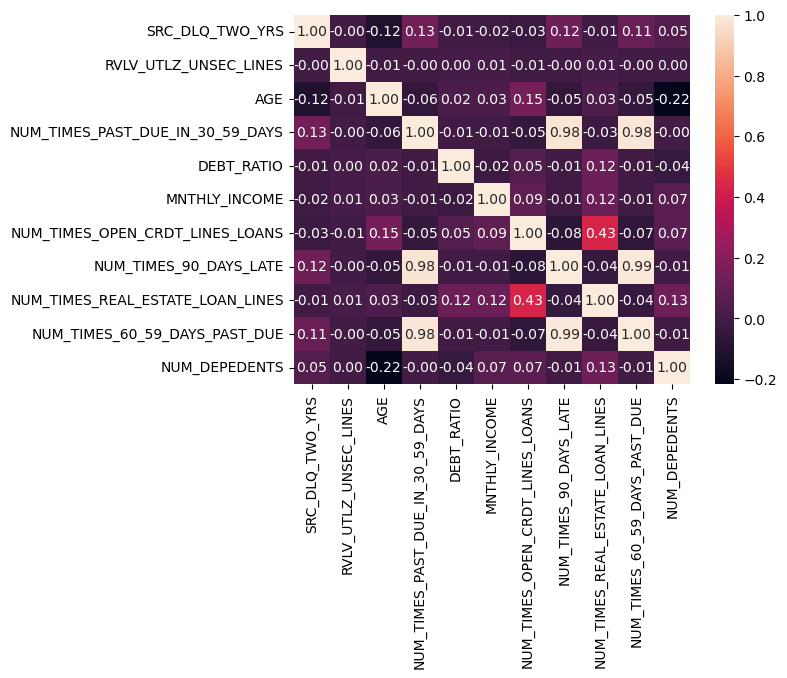

In [34]:
import seaborn as sns

sns.heatmap(train_dataset.corr(), annot=True, fmt=".2f")

In [35]:
##evaluate function for classification models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# For classification models
def evaluate_classification_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1


In [36]:

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time


from sklearn.compose import ColumnTransformer


##commenting other models after evaluating scores

liner_models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    #"SGD Classifier": SGDClassifier(),
    #"K-Neighbors Classifier": KNeighborsClassifier()

}

tree_models = {
    #"Decision Tree": DecisionTreeClassifier(),
    #"Random Forest Classifier": RandomForestClassifier(),
    "GradientBoosting Classifier": GradientBoostingClassifier(), 
    #"XGBClassifier": XGBClassifier(),
    #"CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

models = {**liner_models, **tree_models}

print(type(models))

# Function to train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training and evaluating: {name}")
    start_time = time.perf_counter()

    if name in ["Logistic Regression", "Ridge Classifier", "SGD Classifier", "K-Neighbors Classifier"]:
        model.fit(X_train_scaled_res, y_train_res)
        y_pred = model.predict(X_val_scaled)
    elif name in ["Decision Tree", "Random Forest Classifier", "GradientBoosting Classifier", "CatBoosting Classifier", "AdaBoost Classifier","XGBClassifier"]:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_val)
    
    accuracy, precision, recall, f1 = evaluate_classification_model(y_val, y_pred)
    #print(f"{name} - Recall: {recall:.4f}, F1 Score: {f1:.4f},  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    end_time = time.perf_counter()

    elapsed_time = (end_time - start_time)/60

    print(f"Time take by model  {name} executed in: {elapsed_time:.2f} minutes")

    print('='*55)
    print('\n')


df_results = pd.DataFrame.from_dict(results, orient='index')


df_sorted = df_results.sort_values(by='Recall', ascending=False)

print(df_sorted)


<class 'dict'>
Training and evaluating: Logistic Regression
Time take by model  Logistic Regression executed in: 0.09 minutes


Training and evaluating: Ridge Classifier
Time take by model  Ridge Classifier executed in: 0.01 minutes


Training and evaluating: GradientBoosting Classifier
Time take by model  GradientBoosting Classifier executed in: 1.45 minutes


Training and evaluating: AdaBoost Classifier
Time take by model  AdaBoost Classifier executed in: 0.27 minutes


                             Accuracy  Precision    Recall  F1 Score
AdaBoost Classifier          0.789150   0.193875  0.679820  0.301707
Logistic Regression          0.774859   0.181303  0.671329  0.285502
Ridge Classifier             0.643562   0.112892  0.629870  0.191467
GradientBoosting Classifier  0.865089   0.266621  0.578921  0.365097


                   Accuracy  Precision    Recall  F1 Score
                             
AdaBoost Classifier          0.789150   0.193875    0.679820    0.301707<br>
Logistic Regression          0.774859   0.181303  0.671329  0.285502<br>
Ridge Classifier             0.643562   0.112892  0.629870  0.191467<br>
GradientBoosting Classifier  0.865089   0.266621  0.578921  0.365097<br>
SGD Classifier               0.892968   0.317683  0.520480  0.394548<br>
K-Neighbors Classifier       0.815422   0.181851  0.501499  0.266915<br>
XGBClassifier                0.875230   0.268260  0.499001  0.348935<br>
CatBoosting Classifier       0.881087   0.275932  0.477023  0.349625<br>
Random Forest Classifier     0.890090   0.291341  0.447053  0.352779<br>
Decision Tree                0.834031   0.179215  0.412587  0.249887<br>


Hyperparameter tuning

observations :- the SRC_DLQ_TWO_YRS (depedent feature ) has imbalanced data , thats why used undersampling SMOTE, this increased recall but traded off precision. In credit predictions Recall ( reduce FN ) is important than precision ( reduce FP)

best models to perfrom ( contender for tuning)

AdaBoost Classifier        
Logistic Regression        
GradientBoosting Classifier
SGD Classifier             


In [43]:
## COntender for tuning
#                            Accuracy  Precision    Recall  F1 Score
# AdaBoost Classifier          0.789150   0.193875  0.679820  0.301707
# Logistic Regression          0.774859   0.181303  0.671329  0.285502
# GradientBoosting Classifier  0.865089   0.266621  0.578921  0.365097
# SGD Classifier               0.874494   0.282262  0.565934  0.376662

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV

hyper_models = {
    
    #"SGD Classifier": SGDClassifier(),
    "Logistic Regression": LogisticRegression(),
    "GradientBoosting Classifier": GradientBoostingClassifier(),
    #"AdaBoost Classifier": AdaBoostClassifier(),

}



AdaBoost_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'], 
    'class_weight': [None, 'balanced'],
    'max_iter': [ 300, 500, 1000],
    'solver': ['liblinear']  # 'saga' supports elasticnet
}

gbc_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}
sgd_param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5]
}



params = {
    #"AdaBoost Classifier": AdaBoost_param_grid,
    "Logistic Regression": logreg_param_grid,
    "GradientBoosting Classifier": gbc_param_grid,
    #"SGD Classifier": sgd_param_grid
}

from sklearn.model_selection import RandomizedSearchCV

# Tuning models
tuned_results = {}

for name, model in hyper_models.items():

    print(f"Hyperparam Tuning for: {name}")
    start_time = time.perf_counter()

    model_hyper = models[name]
    param_grid = params[name]

    # rs = RandomizedSearchCV(estimator=model_hyper,
    #                 param_distributions=param_grid,
    #                 n_iter=20,
    #                 n_jobs=-1,
    #                 cv=3,
    #                 verbose=3)

    ##Replace RandomizedSearchCV with HalvingRandomSearchCV for performance
    rs = HalvingRandomSearchCV(estimator=model_hyper,
                           param_distributions=param_grid,
                           factor=3, # or 2, controls how aggressively candidates are pruned
                           min_resources='exhaust', # or a specific number
                           n_candidates=20,
                           n_jobs=-1,
                           cv=3,
                           verbose=3,
                           random_state=42)


    if name in ["Logistic Regression",  "SGD Classifier"]:
        rs.fit(X_train_scaled_res, y_train_res)
        fitted_model = rs.best_estimator_ # Get the best fitted model from the search
        print(f"-------------fitted_model---------:",fitted_model)
        fitted_model.set_params(**rs.best_params_)
        fitted_model.fit(X_train_scaled_res, y_train_res)

        # # Get predicted probabilities for validation data
        y_proba = fitted_model.predict_proba(X_val_scaled)[:, 1]

        # Define input_example for signature inference later
        input_for_signature = X_train_scaled_res        



    elif name in [ "GradientBoosting Classifier", "AdaBoost Classifier"]:
        rs.fit(X_train, y_train)
        fitted_model = rs.best_estimator_ # Get the best fitted model from the search        
        fitted_model.set_params(**rs.best_params_)
        fitted_model.fit(X_train_res, y_train_res)

        # # Get predicted probabilities for validation data
        #y_pred = model.predict(X_val)
        y_proba = fitted_model.predict_proba(X_val)[:, 1]
        
        
        # Define input_example for signature inference later
        input_for_signature = X_train_res

    # Adjust threshold
    threshold = 0.35
    y_pred_adj = (y_proba > threshold).astype(int)

    print (f"{name} hyper param tuning completed")

    roc_score_val = roc_auc_score(y_val, y_pred_adj)


    accuracy, precision, recall, f1 = evaluate_classification_model(y_val, y_pred_adj)
    print(f"{name} - Recall: {recall:.4f}, F1 Score: {f1:.4f},  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, roc_score: {roc_score_val:.4f}")
    print('---'*20)
    print(f"{name} - best_params_: {rs.best_params_}")

    tuned_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "roc_score": roc_score_val,
        "best_params_": rs.best_params_,
        "fitted_model": fitted_model, # Store the actual fitted model
        "input_for_signature": input_for_signature # Store the appropriate input for signature
 
    }
    end_time = time.perf_counter()

    elapsed_time = (end_time - start_time)/60

    print(f"Time take by model  {name} executed in: {elapsed_time:.2f} minutes")

    print('=='*75)
    print('\n')

    
df_results1 = pd.DataFrame.from_dict(tuned_results,orient='index')

df_results_sorted1 = df_results1.sort_values(by='Recall', ascending=False)

print (df_results_sorted1)




2025/10/16 21:21:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4e35183a184c4a1a9b3082bca1b9c100', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/10/16 21:21:27 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Hyperparam Tuning for: Logistic Regression
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 24778
max_resources_: 223010
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 24778
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 74334
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 223002
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2025/10/16 21:21:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec0a7f2d1bb74bdcb4f7366ec28151eb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/10/16 21:21:47 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run smiling-conch-881 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/4e35183a184c4a1a9b3082bca1b9c100
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321
-------------fitted_model---------: LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')
🏃 View run debonair-bird-511 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/ec0a7f2d1bb74bdcb4f7366ec28151eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321
Logistic Regression hyper param tuning completed
Logistic Regression - Recall: 0.8871, F1 Score: 0.1819,  Accuracy: 0.4655, Precision: 0.1014, roc_score: 0.6612
------------------------------------------------------------
Logistic Regression - best_params_: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'class_weight': None, 'C': 10}
Time take by model  Logistic Regression executed in: 0.52 minutes


Hyperparam Tuning for: GradientBoosting Classifier


2025/10/16 21:21:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '114fae26894449a78e3446a59db69e9f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 13279
max_resources_: 119512
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 13279
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 39837
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 119511
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2025/10/16 21:27:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3af8246d04524a94afec1f259bd39af2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run fun-goat-457 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/114fae26894449a78e3446a59db69e9f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321
🏃 View run whimsical-deer-179 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/3af8246d04524a94afec1f259bd39af2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321
GradientBoosting Classifier hyper param tuning completed
GradientBoosting Classifier - Recall: 0.8112, F1 Score: 0.2717,  Accuracy: 0.7086, Precision: 0.1632, roc_score: 0.7562
------------------------------------------------------------
GradientBoosting Classifier - best_params_: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.05}
Time take by model  GradientBoosting Classifier executed in: 7.50 minutes


                             Accuracy  Precision    Recall  F1 Score  \
Logistic Regression          0.465477   0.101364  0.887113  0.181

In [45]:
##ML flow tracking for hyperparameter tuning


mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

mlflow.set_experiment(experiment_name="Credit Risk Prediction")

mlflow.autolog()

with mlflow.start_run():
    for name, result_data in tuned_results.items():
        print(f"Logging hyperparam tuning for : {name}")

        fitted_model = result_data['fitted_model']
        best_params = result_data['best_params_']
        input_for_signature = result_data['input_for_signature']

        mlflow.log_param("model_name", name)
        mlflow.log_param("model", fitted_model)
        mlflow.log_params(best_params)
        mlflow.log_param("Recall", result_data['Recall'])
        mlflow.log_param("Precision", result_data['Precision'])
        mlflow.log_metric("F1 Score", result_data['F1 Score'])
        mlflow.log_metric("Accuracy", result_data['Accuracy']) # Log accuracy
        mlflow.log_metric("ROC_AUC_Score", result_data['roc_score']) # Log ROC AUC score


        ##infer the model signature
        signature = infer_signature(input_for_signature, fitted_model.predict(input_for_signature))

        model_info = mlflow.sklearn.log_model(
            sk_model=fitted_model, 
            artifact_path= "model", 
            signature=signature,
            input_example=input_for_signature,
            registered_model_name=f"Credit Risk Prediction {name}"
        )


        mlflow.end_run()


2025/10/16 21:36:57 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/10/16 21:36:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/10/16 21:36:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/16 21:36:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/10/16 21:36:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/10/16 21:36:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging hyperparam tuning for : Logistic Regression


Registered model 'Credit Risk Prediction Logistic Regression' already exists. Creating a new version of this model...
2025/10/16 21:37:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit Risk Prediction Logistic Regression, version 2
Created version '2' of model 'Credit Risk Prediction Logistic Regression'.


🏃 View run useful-robin-580 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/822dfcb84cbd470882f7c8d8cee3c494
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321
Logging hyperparam tuning for : GradientBoosting Classifier


2025/10/16 21:37:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registered model 'Credit Risk Prediction GradientBoosting Classifier' already exists. Creating a new version of this model...
2025/10/16 21:38:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit Risk Prediction GradientBoosting Classifier, version 2
Created version '2' of model 'Credit Risk Prediction GradientBoosting Classifier'.


🏃 View run overjoyed-snipe-24 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/04a7c5c4ffcc4205b3f4a8181f269b6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321


Best hyperparameters <br>

Hyperparam Tuning for: GradientBoosting Classifier<br>
Fitting 3 folds for each of 20 candidates, totalling 60 fits<br>
GradientBoosting Classifier hyper param tuning completed<br>
GradientBoosting Classifier - Recall: 0.7478, F1 Score: 0.3083,  Accuracy: 0.7752, Precision: 0.1942<br><br>

Logistic Regression - best_params_: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'class_weight': None, 'C': 100}


Hyperparam Tuning for: Logistic Regression<br>
Fitting 3 folds for each of 20 candidates, totalling 60 fits<br>
Logistic Regression hyper param tuning completed<br>
Logistic Regression - Recall: 0.8871, F1 Score: 0.1819,  Accuracy: 0.4655, Precision: 0.1014<br>

GradientBoosting Classifier - best_params_: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.05}
Time take by model  GradientBoosting Classifier executed in: 9.80 minutes


In [46]:
df_results1 = pd.DataFrame.from_dict(tuned_results,orient='index')

df_results_sorted1 = df_results1.sort_values(by='Recall', ascending=False)

print (df_results_sorted1)

                             Accuracy  Precision    Recall  F1 Score  \
Logistic Regression          0.465477   0.101364  0.887113  0.181939   
GradientBoosting Classifier  0.708625   0.163183  0.811189  0.271708   

                             roc_score  \
Logistic Regression           0.661155   
GradientBoosting Classifier   0.756224   

                                                                  best_params_  \
Logistic Regression          {'solver': 'liblinear', 'penalty': 'l1', 'max_...   
GradientBoosting Classifier  {'subsample': 0.8, 'n_estimators': 100, 'min_s...   

                                                                  fitted_model  \
Logistic Regression          LogisticRegression(C=10, max_iter=1000, penalt...   
GradientBoosting Classifier  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                                           input_for_signature  
Logistic Regression          [[-0.02095823615691226, 0.8605369464834299, -0...  


In [47]:
print(tuned_results['GradientBoosting Classifier'])

{'Accuracy': 0.7086247866394457, 'Precision': 0.16318327974276528, 'Recall': 0.8111888111888111, 'F1 Score': 0.27170821482349006, 'roc_score': np.float64(0.7562239568373657), 'best_params_': {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.05}, 'fitted_model': GradientBoostingClassifier(learning_rate=0.05, min_samples_split=5,
                           subsample=0.8), 'input_for_signature':         RVLV_UTLZ_UNSEC_LINES  AGE  NUM_TIMES_PAST_DUE_IN_30_59_DAYS  \
0                    0.628651   65                                 0   
1                    0.011567   80                                 0   
2                    0.131268   79                                 0   
3                    1.000000   27                                 0   
4                    0.115464   67                                 0   
...                       ...  ...                               ...   
223005               0.573632   35                 

In [48]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_auc = roc_auc_score(y_val, y_proba)
pr_auc = average_precision_score(y_val, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

ROC-AUC: 0.8335, PR-AUC: 0.3378


## Create genric ROC AUC Curve template

2025/10/16 21:43:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f7f18ee48fb54ecba6cedeabf2192997', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/10/16 21:43:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run salty-stag-209 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/f7f18ee48fb54ecba6cedeabf2192997
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321


2025/10/16 21:43:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ee31e2d8d2f34f5aa923438857501595', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run fearless-shad-270 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/ee31e2d8d2f34f5aa923438857501595
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321


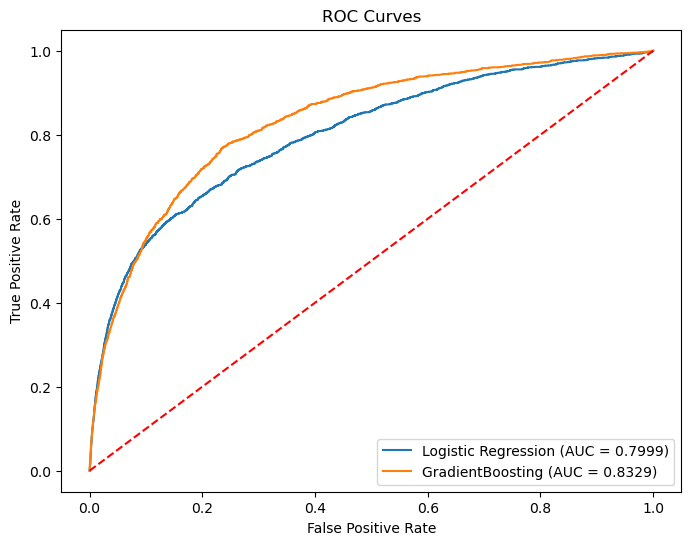

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

roc_models_to_plot = []

models = [

    {'label': 'Logistic Regression', 
     'model': LogisticRegression(solver='liblinear', penalty='l1', max_iter= 500, class_weight= None, C=10),
     'auc':0.6611
    },
    {
        'label': 'GradientBoosting', 
        'model': GradientBoostingClassifier(),
        'auc':0.5691
    }
]


for m in models:
    model = m['model']
    label = m['label']
    auc = m['auc']

    if label == 'Logistic Regression':
        model.fit(X_train_scaled_res, y_train_res)
        y_proba = m['model'].predict_proba(X_val_scaled)[:, 1]
        # fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    else :
        model.fit(X_train_res, y_train_res)
        y_proba = m['model'].predict_proba(X_val)[:, 1]
        
        
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    actual_auc = roc_auc_score(y_val, y_proba)
    #plt.plot(fpr, tpr, label=f'{label} (AUC = {actual_auc:.4f})')

    roc_models_to_plot.append({
        'label': label,
        'fpr': fpr,
        'tpr': tpr,
        'auc': actual_auc
    })

for m_plot in roc_models_to_plot:
    plt.plot(m_plot['fpr'],m_plot['tpr'], label=f'{m_plot["label"]} (AUC = {m_plot["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


GradientBoosting is better in terms of overall, recall is less  but  precision and f1 is better, so test set should be trained using gradient boosing and best params

## Test dataset traning

In [50]:
test_dataset.isnull().sum()

SRC_DLQ_TWO_YRS                     101175
RVLV_UTLZ_UNSEC_LINES                    0
AGE                                      0
NUM_TIMES_PAST_DUE_IN_30_59_DAYS         0
DEBT_RATIO                               0
MNTHLY_INCOME                            0
NUM_TIMES_OPEN_CRDT_LINES_LOANS          0
NUM_TIMES_90_DAYS_LATE                   0
NUM_TIMES_REAL_ESTATE_LOAN_LINES         0
NUM_TIMES_60_59_DAYS_PAST_DUE            0
NUM_DEPEDENTS                            0
dtype: int64

In [51]:
test_dataset.duplicated().sum()

np.int64(109)

In [52]:
test_dataset = test_dataset.drop_duplicates(keep='first').reset_index(drop=True)

In [53]:
test_dataset.duplicated().sum()

np.int64(0)

In [54]:
#test data input and output split

X_test = test_dataset.drop(columns=['SRC_DLQ_TWO_YRS'], axis=1)
y_test = test_dataset['SRC_DLQ_TWO_YRS']

In [55]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101066 entries, 0 to 101065
Data columns (total 10 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   RVLV_UTLZ_UNSEC_LINES             101066 non-null  float64
 1   AGE                               101066 non-null  int64  
 2   NUM_TIMES_PAST_DUE_IN_30_59_DAYS  101066 non-null  int64  
 3   DEBT_RATIO                        101066 non-null  float64
 4   MNTHLY_INCOME                     101066 non-null  float64
 5   NUM_TIMES_OPEN_CRDT_LINES_LOANS   101066 non-null  int64  
 6   NUM_TIMES_90_DAYS_LATE            101066 non-null  int64  
 7   NUM_TIMES_REAL_ESTATE_LOAN_LINES  101066 non-null  int64  
 8   NUM_TIMES_60_59_DAYS_PAST_DUE     101066 non-null  int64  
 9   NUM_DEPEDENTS                     101066 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 7.7 MB


In [56]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 101066 entries, 0 to 101065
Series name: SRC_DLQ_TWO_YRS
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 789.7+ KB


In [57]:
##no Feature scaling and undersamping required as gradient boosting is getting used

# from imblearn.over_sampling import SMOTE ## to make model learn from minority class
# from imblearn.under_sampling import RandomUnderSampler

# smote = SMOTE(random_state=42)
# X_test_res = smote.fit_resample(X_test)




In [58]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(subsample= 0.8, n_estimators= 100, min_samples_split= 5, max_depth= 3, learning_rate= 0.05)

gbc.fit(X_train_res, y_train_res) ## train on training dataset

y_pred_on_test = gbc.predict(X_test)

#to get probabilities (e.g., for a custom threshold)
y_proba_on_test = gbc.predict_proba(X_test)[:, 1]

2025/10/16 21:45:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '677861bc5b16433ebe96ac937126c7e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run merciful-fawn-558 at: http://127.0.0.1:5000/#/experiments/900997911555713321/runs/677861bc5b16433ebe96ac937126c7e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/900997911555713321


In [59]:
print(y_proba_on_test)

[0.59399375 0.32905246 0.09185859 ... 0.12536714 0.33462626 0.44815356]


In [60]:
# Create a copy of X_test to avoid modifying the original DataFrame directly
X_test_with_predictions = X_test.copy()

X_test_with_predictions['SRC_DLQ_TWO_YRS_PREDICTED'] = y_pred_on_test

X_test_with_predictions['PREDICTED_PROBABILITY'] = y_proba_on_test

In [61]:
# Display the head of the new DataFrame to verify
#print(X_test_with_predictions.head())

X_test_with_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101066 entries, 0 to 101065
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   RVLV_UTLZ_UNSEC_LINES             101066 non-null  float64
 1   AGE                               101066 non-null  int64  
 2   NUM_TIMES_PAST_DUE_IN_30_59_DAYS  101066 non-null  int64  
 3   DEBT_RATIO                        101066 non-null  float64
 4   MNTHLY_INCOME                     101066 non-null  float64
 5   NUM_TIMES_OPEN_CRDT_LINES_LOANS   101066 non-null  int64  
 6   NUM_TIMES_90_DAYS_LATE            101066 non-null  int64  
 7   NUM_TIMES_REAL_ESTATE_LOAN_LINES  101066 non-null  int64  
 8   NUM_TIMES_60_59_DAYS_PAST_DUE     101066 non-null  int64  
 9   NUM_DEPEDENTS                     101066 non-null  float64
 10  SRC_DLQ_TWO_YRS_PREDICTED         101066 non-null  int64  
 11  PREDICTED_PROBABILITY             101066 non-null  f

## write data in snowflake table

In [ ]:
from snowflake.connector.pandas_tools import write_pandas


snowflake_table_name = "CS_PREDICT"

load_dotenv(dotenv_path="../cred.env")

database=os.getenv("SNOWFLAKE_DB")

print(database)




raw_write_result = write_pandas(
    conn,
    X_test_with_predictions,
    table_name = snowflake_table_name,
    database=os.getenv('SNOWFLAKE_DB').upper(),
    schema=os.getenv('SNOWFLAKE_SCHEMA').upper(),
    auto_create_table=True, 
    overwrite=True 
)

print(f"DEBUG: Raw result from write_pandas: {raw_write_result}")
print(f"DEBUG: Type of raw_write_result: {type(raw_write_result)}")
if hasattr(raw_write_result, '__len__'):
    print(f"DEBUG: Length of raw_write_result: {len(raw_write_result)}")


try:
    success, n_chunks, n_rows, *extra_values = raw_write_result
    if extra_values:
        print(f"WARNING: write_pandas returned unexpected extra values: {extra_values}")
except ValueError as e:
    print(f"ERROR: Could not unpack write_pandas result. The structure is not (success, n_chunks, n_rows, *extra_values). Error: {e}")
    # Re-raise or handle as appropriate if the structure is completely different
    raise

print(f"Number of chunks: {n_chunks}")

if success:
    print(f"Successfully wrote {n_rows} rows to Snowflake table '{snowflake_table_name}'.")
else:
    print(f"Failed to write data to Snowflake table '{snowflake_table_name}'.")
    if extra_values:
        print(f"Additional details: {extra_values}")


CREDIT_RISK_PREDICTION
DEBUG: Raw result from write_pandas: (True, 1, 101066, [('snowpark_temp_stage_8zzd74cj05/file0.txt', 'LOADED', 101066, 101066, 1, 0, None, None, None, None)])
DEBUG: Type of raw_write_result: <class 'tuple'>
DEBUG: Length of raw_write_result: 4
Number of chunks: 1
Successfully wrote 101066 rows to Snowflake table 'CS_PREDICT'.


In [65]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
for mv in client.search_model_versions("name='Credit Risk Prediction GradientBoosting Classifier'"):
    print(f"Version: {mv.version}, Stage: {mv.current_stage}, Run ID: {mv.run_id}")

Version: 5, Stage: None, Run ID: 9a77c40246dc4a3bbde948ed3bcd47c0
Version: 4, Stage: None, Run ID: 822dfcb84cbd470882f7c8d8cee3c494
Version: 3, Stage: None, Run ID: 822dfcb84cbd470882f7c8d8cee3c494
Version: 2, Stage: None, Run ID: 04a7c5c4ffcc4205b3f4a8181f269b6a
Version: 1, Stage: None, Run ID: 9a77c40246dc4a3bbde948ed3bcd47c0
